# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

This is possibly the worst structured code I've ever written, sorry!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

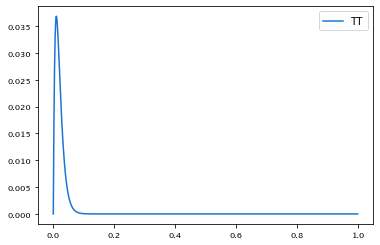

In [3]:
time, imp = make_impulse(w_TT, z_TT)
plt.plot(time, imp, label="TT")
plt.legend() 

In [4]:
num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [5]:
A_TT, B_TT, C_TT, D_TT

(array([[ 1.80967484, -0.81873075],
        [ 1.        ,  0.        ]]), array([[1.],
        [0.]]), array([[0.00467884, 0.00437708]]), array([[0.]]))

In [6]:
Q_TT = 1e-4 * np.array([[1, 0], [0, 0]]) # mas^2, arbitrary

In [7]:
# now, let's import the usual Kalman filter! at first, no vibrations.

size = 5000
vibe = make_1D_vibe_data(steps=size, N=1)
pol = vibe
kfilter_vibe = make_kfilter_vibe(*vibe_fit_freq(get_psd(vibe[:1000]), N=1))

Took 316 iterations to get steady-state covariance.


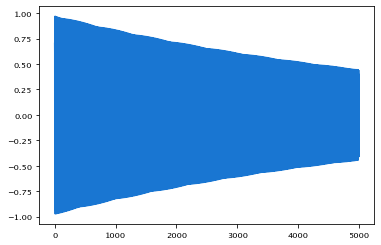

In [8]:
plt.plot(vibe)

In [9]:
hasattr(kfilter_vibe, "B")

False

In [40]:
res, phy = kfilter_vibe.run(vibe + np.random.normal(0, 0.06, vibe.size), save_physics=True)

In [41]:
rms(vibe[316:] - res[316:])

0.026310850849863163

In [30]:
kfilter_TT = KFilter(np.zeros(2,), A_TT, B_TT.flatten(), Q_TT, C_TT, np.array([eps]), has_input=True)
# the Q and R don't matter because I'm setting the Kalman gain to zero

Took 8 iterations to get steady-state covariance.


In [12]:
state_WFS = np.array([0, 0])
A_WFS = np.array([[0, 0], [1, 0]])
B_WFS = np.array([1, 0]) # takes in residual at timestep k
H_WFS = np.array([[0, 1]])
Q_WFS = np.identity(2) 
R_WFS = np.array([eps])
# the Q and R don't matter because I'm setting the Kalman gain to zero

kfilter_WFS = KFilter(state_WFS, A_WFS, B_WFS, Q_WFS, H_WFS, R_WFS, has_input=True)
kfilter_WFS.K

Took 1 iterations to get steady-state covariance.


array([[0.],
       [1.]])

In [13]:
kfilter = kfilter_WFS + kfilter_vibe + kfilter_TT
kfilter.H = np.array([[0, 1, 0]]).dot(kfilter.H)

In [14]:
N_WFS = 2 # two frame delay
N_vibe = kfilter_vibe.state.size
N_CM = 2 # second order control loop model
N_state = N_WFS + N_vibe + N_CM
N_frames = 2
B_temp = B_WFS.reshape((B_WFS.size,1))
temp1 = B_temp.dot(kfilter_vibe.H)
temp2 = -B_temp.dot(C_TT)

In [15]:
# hardcoding because some things are just plain weird
kfilter.B = np.array(([0] * (N_WFS + N_vibe)) + list(B_TT.flatten()))

In [16]:
for i, j in [(0, 2), (0, 3), (1, 2), (1, 3)]: # works with a hardcoded N_WFS = 2
    kfilter.A[i][j] = temp1[i][j-2]
    kfilter.A[i][j+2] = temp2[i][j-2]

In [17]:
# at this point, the filter should be set up properly
kfilter.state = np.zeros(kfilter.A.shape[0],)
res, phy = kfilter.run(pol + np.random.normal(0, 0.06, pol.size), np.zeros(pol.size,), save_physics=True)

In [18]:
y, u = 1, 5
R_y = np.identity(N_frames) * y
R_u = np.identity(N_frames) * u
C_0 = np.vstack([kfilter.H.dot(kfilter.A ** i) for i in range(N_frames)])
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [19]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = float(max(np.diff(pol[:5000]))) # arbitrary
G = np.identity(N_frames)
h = np.vstack([u_max] * N_frames)

In [20]:
solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')['x']

     pcost       dcost       gap    pres   dres
 0:  2.6806e-01 -2.1939e+00  2e+00  3e-17  3e+00
 1:  2.7238e-05 -3.1650e-02  3e-02  6e-17  3e-02
 2:  2.7237e-09 -3.1727e-04  3e-04  2e-16  3e-04
 3:  2.7237e-13 -3.1727e-06  3e-06  1e-16  3e-06
 4:  2.7237e-17 -3.1727e-08  3e-08  3e-16  3e-08
Optimal solution found.


In [21]:
np.array(solution) # should be zero or almost zero, because the state's zero

array([[2.56679154e-09],
       [1.89434188e-09]])

In [22]:
kfilter.state = np.zeros(kfilter.A.shape[0],)

shifts = np.diff(pol)
res_control = np.zeros(pol.shape)
res_control[0] = pol[0]
actions = np.zeros(pol.shape)
for i in range(1, pol.size):
    try:
        res_control[i] = res_control[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res_control[i] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        if i < pol.size - N_frames + 1 and i % N_frames == 0:
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')
            for j in range(i, i + N_frames):
                actions[j] = solution['x'][j - i]

        kfilter.predict(actions[i])
        
    except:
        print(i)
        raise

In [23]:
rms(pol)

0.4906023016256402

In [24]:
rms(res_control)

0.4535185736534382

In [25]:
print(max(actions))
print(u_max)

0.3182473963558221
1.432298055158793


(1e-10, 41.01380219929691)

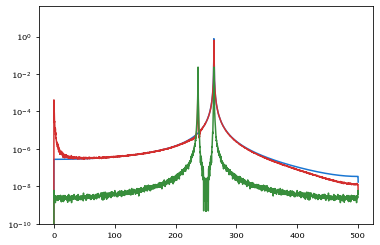

In [26]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.semilogy(*signal.periodogram(res_control, fs=f_sampling))
plt.semilogy(*signal.periodogram(actions, fs=f_sampling))
plt.ylim(1e-10)